In [1]:
from keras.preprocessing import image
from keras.layers import Input, Dense
from keras.models import Model

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)


In [3]:
img = image.load_img('data/train/n01443537/images/n01443537_0.JPEG')
# img = image.load_img('data/ILSVRC/Data/DET/test/ILSVRC2017_test_00003121.JPEG', target_size=IMG_SHAPE)
x = image.img_to_array(img)  # this is a Numpy array with shape (3, 64, 64)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 64, 64)

In [4]:
# Making sure data is in the right shape
x.shape

(1, 64, 64, 3)

In [5]:
#Model
from keras.models import Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

## Dataset creation
The dataset is composed of a random subset of images from all 200 classes.

In [6]:
test_size = 500

def load_dataset_small(n_images_from_class_test=10, test_size=500):
    X_train = []
    X_test = []
    
    # Create training set
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        
        for img_name_i in c_imgs[0:n_images_from_class_test]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
            
    # Create test set
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:test_size]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)
        
        

    return np.array(X_train), np.array(X_test)
    
def load_dataset(n_images=2000):
    IMG_DIR = "./data/ILSVRC/Data/DET/test"
    X_train = []
    
    img_names = os.listdir(IMG_DIR)
    random.shuffle(img_names)
    
    for img_name_i in img_names[0:n_images]:
        img_i = image.load_img(os.path.join(IMG_DIR, img_name_i), target_size=IMG_SHAPE)
        x = image.img_to_array(img_i)
        X_train.append(x)
        
    return np.array(X_train)
        

In [7]:
X_train_orig, X_test_orig = load_dataset_small()
# X_train_orig = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [8]:
# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

# TODO Do the same for test images

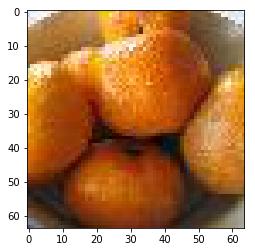

In [9]:
plt.imshow(X_train[3])

## Model

In [10]:
from keras.layers import concatenate, Conv2D
import keras.backend as K

noise_std = 0.01
beta = 1.0
def model_loss(y_true, y_pred):
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return c_loss + beta * s_loss

def create_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    # Prep network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    # Gaussian noise
    output_Cprime_noise = GaussianNoise(noise_std, name='output_C_noise')(output_Cprime)
    
    # Reveal network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(output_Cprime_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(output_Cprime_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(output_Cprime_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    assert (output_Cprime.shape[3] == 3)
    assert (output_Sprime.shape[3] == 3)
    
    # Models
    autoencoder = Model(inputs=[input_S, input_C], outputs=concatenate([output_Sprime, output_Cprime]), name = 'AutoEncoderModel')

    # encoder = Model(inputs=[input_S, input_C], outputs=output_Cprime)
    
    # encoded_input = Input(shape=(input_size))
    # decoder_c_layer = autoencoder.get_layer('c_prime')
    # decoder_s_layer = autoencoder.get_layer('s_prime')
    # decoder = Model(inputs=encoded_input, outputs=[decoder_s_layer(encoded_input), decoder_c_layer(encoded_input)])
        
    return autoencoder #, encoder, decoder

In [11]:
autoencoder_model = create_model(input_S.shape[1:])

autoencoder_model.compile(optimizer='adam', loss=model_loss)

In [12]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(autoencoder_model).create(prog='dot', format='svg'))

## Training

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 250:
        return 0.001
    elif epoch_idx < 350:
        return 0.0001
    else:
        return 0.00003
    

checkpointer = ModelCheckpoint(filepath='models/weights_muz2.hdf5', verbose=0)
scheduler = LearningRateScheduler(lr_schedule)

autoencoder_model.fit([input_S, input_C], 
                      np.concatenate((input_S, input_C),axis=3),
                      epochs=500,
                      batch_size=32,
                      callbacks=[checkpointer, scheduler])

Epoch 1/500
1000/1000 [==============================] - 23s 23ms/step - loss: 62914.4274
Epoch 2/500
1000/1000 [==============================] - 21s 21ms/step - loss: 42684.1998
Epoch 3/500
1000/1000 [==============================] - 21s 21ms/step - loss: 46057.3200
Epoch 4/500
1000/1000 [==============================] - 21s 21ms/step - loss: 36371.1436
Epoch 5/500
1000/1000 [==============================] - 21s 21ms/step - loss: 26837.8206
Epoch 6/500
1000/1000 [==============================] - 21s 21ms/step - loss: 20073.8836
Epoch 7/500
1000/1000 [==============================] - 21s 21ms/step - loss: 15435.4286
Epoch 8/500
1000/1000 [==============================] - 21s 21ms/step - loss: 13018.0929
Epoch 9/500
 352/1000 [=========>....................] - ETA: 13s - loss: 12095.9492

In [ ]:
# Load model
# autoencoder_model.load_weights('models/small_train_checkpoint.hdf5')

## Results

In [60]:
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [101]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [99]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 8.28608
C error per pixel [0, 255]: 11.0319


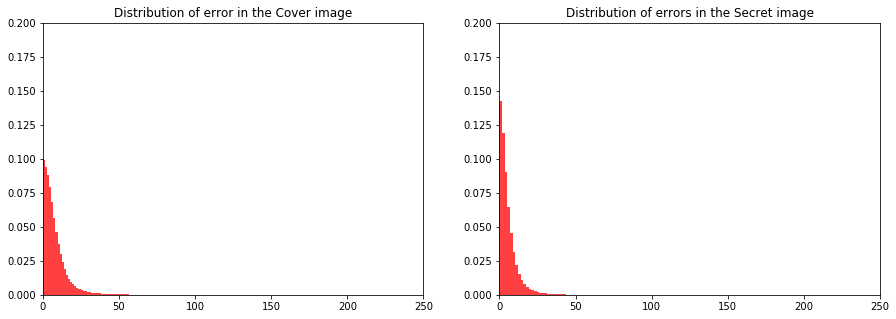

In [100]:
pixel_histogram(diff_S, diff_C)

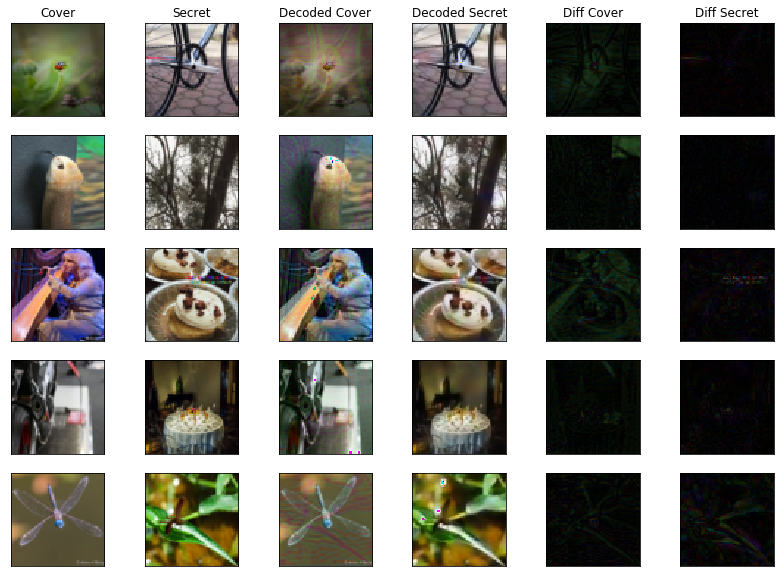

In [63]:
# Config for results display

# Show images in gray scale
SHOW_GRAY = False

# Show image diff
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

n = 5

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 10))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Decoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()